In [1]:
import sys
import os

from string import punctuation
import datetime
from tqdm import tqdm

from collections import Counter
import numpy as np
import pandas as pd

# import wordcloud as wc
import pycountry as pc
import pycountry_convert as pcc
import nltk
from emoji import UNICODE_EMOJI
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
if sys.platform == 'darwin':
    font_path = '/Users/juan/Library/Fonts/Apple Color Emoji.ttc'
elif sys.platform == 'linux':
    font_path = '/usr/local/share/fonts/emojione-android.ttf'
prop = mfm.FontProperties(fname=font_path) # find this font
plt.rcParams['font.family'] = prop.get_family()
# sns.set()
%matplotlib inline
print('MatPlotLib backend is',mpl.get_backend())

# ## https://github.com/wireapp/wire-desktop/wiki/Colorful-emojis-on-Linux
# from fontTools.ttLib import TTFont
# def char_in_font(Unicode_char, font):
#     for cmap in font['cmap'].tables:
#         if cmap.isUnicode():
#             if ord(Unicode_char) in cmap.cmap:
#                 return True
#     return False
# uni_char = '\U0001f469'
# print("emoji %s in font?"%uni_char,char_in_font(uni_char, TTFont(font_path, fontNumber=0)))
# plt.annotate("😅", (0.5, 0.3), size=30)
# plt.annotate("😢", (0.5, 0.8), size=30)
# plt.annotate(uni_char, (0.5, 0.5), size=30)

flatten = lambda l: [item for sublist in l for item in sublist]

MatPlotLib backend is module://ipykernel.pylab.backend_inline


# Ejemplo de Twitter: ver [vínculo](https://towardsdatascience.com/tweepy-for-beginners-24baf21f2c25)

In [2]:
import tweepy

class TweetMiner(object):

    result_limit    =   20    
    data            =   []
    api             =   False

    twitter_keys = {
        'consumer_key':        'oTLqvmc5I8KT9XJLTeY3O3eux',
        'consumer_secret':     'Mv97oefVHiA9Zeu0874LVlbQg9eIlOJjCKM4VrXlfzAOv6cGeL',
        'access_token_key':    '363315072-oTTGdUEE3yolCvl5h4de0Bu6CysOVnRRALbDucR9',
        'access_token_secret': '4kNrT9HRYTM1RIBUgBnK8Mlm9waq6C5YhTxqHSV1jPgbw'
    }
    
    tweet_mode = 'extended'

    def __init__(self, keys_dict=twitter_keys, api=api, result_limit = 20):
        self.twitter_keys = keys_dict
        auth = tweepy.OAuthHandler(keys_dict['consumer_key'], keys_dict['consumer_secret'])
        auth.set_access_token(keys_dict['access_token_key'], keys_dict['access_token_secret'])
        self.api = tweepy.API(auth,retry_count=10, retry_delay=5, retry_errors=set([503]))
        self.twitter_keys = keys_dict
        self.result_limit = result_limit
        

    def mine_user_tweets(
        self, user="nytimes",
        mine_rewteets=False,
        max_pages=20
    ):
        data           =  []
        last_tweet_id  =  False
        page           =  1
        while page <= max_pages:
            if last_tweet_id:
                statuses   =   self.api.user_timeline(screen_name=user,
                    count=self.result_limit,
                    max_id=last_tweet_id - 1,
                    tweet_mode = 'extended',
                    include_retweets=mine_rewteets
                )        
            else:
                statuses   =   self.api.user_timeline(screen_name=user,
                    count=self.result_limit,
                    tweet_mode = 'extended',
                    include_retweets=mine_rewteets
                )
                
            for item in statuses:
                mined = {
                    'tweet_id':        item.id,
                    'name':            item.user.name,
                    'screen_name':     item.user.screen_name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.full_text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                    'favourite_count': item.favorite_count,
                    'hashtags':        item.entities['hashtags'],
                    'status_count':    item.user.statuses_count,
                    'location':        item.place,
                    'source_device':   item.source
                }
                try:
                    mined['retweet_text'] = item.retweeted_status.full_text
                except:
                    mined['retweet_text'] = 'None'
                try:
                    mined['quote_text'] = item.quoted_status.full_text
                    mined['quote_screen_name'] = status.quoted_status.user.screen_name
                except:
                    mined['quote_text'] = 'None'
                    mined['quote_screen_name'] = 'None'
                last_tweet_id = item.id
                data.append(mined)
            page += 1
            
        return data

In [3]:
miner=TweetMiner(result_limit = 200)
mined_tweets = pd.DataFrame(miner.mine_user_tweets(user='MariaFdaCabal', max_pages=10))

In [4]:
mined_tweets.text = mined_tweets.text.apply(lambda x: x.lower())
mined_tweets.retweet_text = mined_tweets.retweet_text.apply(lambda x: x.lower())
mined_tweets['TEXT'] = mined_tweets.loc[:,['text','retweet_text']].apply(
    lambda x: x['text'] if x['retweet_text'] == 'none' else x['retweet_text'],
    axis=1
)
mined_tweets[:2]

,tweet_id,name,screen_name,retweet_count,text,mined_at,created_at,favourite_count,hashtags,status_count,location,source_device,retweet_text,quote_text,quote_screen_name,TEXT
0,1244797082181001219,María Fernanda Cabal,MariaFdaCabal,18,https://t.co/5m295aztxs,2020-03-30 23:54:09.279385,2020-03-31 01:22:06,48,[],65510,None,Twitter for iPhone,none,None,None,https://t.co/5m295aztxs
1,1244768872026247172,María Fernanda Cabal,MariaFdaCabal,34,"#columna | ""aquí hace justicia recordar que ha...",2020-03-30 23:54:09.279398,2020-03-30 23:30:00,76,"[{'text': 'Columna', 'indices': [0, 8]}]",65510,None,TweetDeck,none,None,None,"#columna | ""aquí hace justicia recordar que ha..."


In [5]:
print("Número de Tweets originales: %d (%.2lf%%)"%(
    np.sum(mined_tweets.retweet_text == 'none'),
    np.sum(mined_tweets.retweet_text == 'none')*100/len(mined_tweets)
))

Número de Tweets originales: 784 (39.30%)


In [6]:
print("Número de Tweets replicados (retweets): %d (%.2lf%%)"%(
    np.sum(mined_tweets.retweet_text != 'none'),
    np.sum(mined_tweets.retweet_text != 'none')*100/len(mined_tweets)
))

Número de Tweets replicados (retweets): 1211 (60.70%)


## Histograma de longitud de tweets con y sin espacios

Cuando revisamos los tweets en el modo extendido para ver todos los caracteres, hay que tener presente que el campo `text` está truncado por defecto cuando haces un retweet. De lo contrario no lo trunca. Entonces, podemos hacer la estadística de longitud de tweets y retweets y luego juntos

### Sólo Tweets

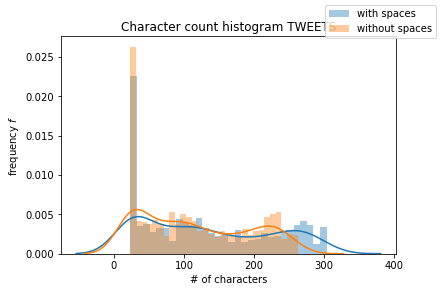

In [7]:
fig = plt.figure()
tmparr1 = mined_tweets.apply(
    lambda x: len(x['text']) if x['retweet_text'] == 'none' else -1,
    axis=1
)
tmparr1a = mined_tweets.apply(
    lambda x: len(x['text'].replace(' ','')) if x['retweet_text'] == 'none' else -1,
    axis=1
)
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr1)
    ),bins=30
)
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr1a)
    ),bins=30
)
fig.legend(labels=['with spaces','without spaces'])
ax = fig.get_axes()
ax[0].set_title('Character count histogram TWEETS')
ax[0].set_xlabel('# of characters')
ax[0].set_ylabel('frequency $f$')
plt.show()

### Sólo Retweets

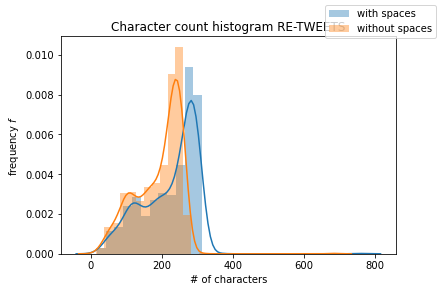

In [8]:
fig = plt.figure()
tmparr2 = mined_tweets.apply(
    lambda x: len(x['retweet_text']) if x['retweet_text'] != 'none' else -1,
    axis=1
)
tmparr2a = mined_tweets.apply(
    lambda x: len(x['retweet_text'].replace(' ','')) if x['retweet_text'] != 'none' else -1,
    axis=1
)
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr2)
    ),bins=30
)
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr2a)
    ),bins=30
)
fig.legend(labels=['with spaces','without spaces'])
ax = fig.get_axes()
ax[0].set_title('Character count histogram RE-TWEETS')
ax[0].set_xlabel('# of characters')
ax[0].set_ylabel('frequency $f$')
plt.show()

### Tweets y Retweets juntos

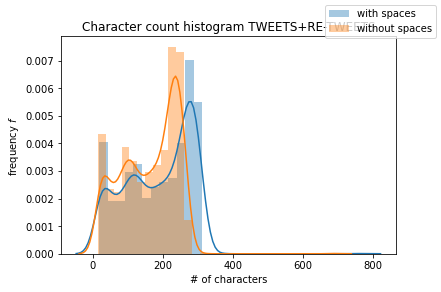

In [9]:
fig = plt.figure()
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr1)
    ) + list(
        filter(lambda x: x >= 0,tmparr2)
    ),bins=30
)
sns.distplot(
    list(
        filter(lambda x: x >= 0,tmparr1a)
    ) + list(
        filter(lambda x: x >= 0,tmparr2a)
    ),bins=30
)
fig.legend(labels=['with spaces','without spaces'])
ax = fig.get_axes()
ax[0].set_title('Character count histogram TWEETS+RE-TWEETS')
ax[0].set_xlabel('# of characters')
ax[0].set_ylabel('frequency $f$')
plt.show()

### ¿Por qué tenemos Tweets con tantos caracteres?
Seguramente es por las menciones (@), las cadenas (#) o los vínculos (http...)

In [10]:
rangos = (50,100,150,200,250,300,np.inf)
num_tweets1 = [ np.sum(tmparr1 <= it) for it in rangos ]
num_tweets2 = [ np.sum(tmparr2 <= it) for it in rangos ]
num_tweets1 = [ nt - (
    num_tweets1[it-1] if it > 0 else 0
) for it,nt in enumerate(num_tweets1) ]
num_tweets2 = [ nt - (
    num_tweets2[it-1] if it > 0 else 0
) for it,nt in enumerate(num_tweets2) ]
print("""
    Tabla de rangos de número de caracteres vs
    frecuencia para los Tweets/Retweets
""")
pd.DataFrame(
    list(zip(rangos,num_tweets1,num_tweets2)),
    columns=['max # chars','freq:tweets','freq:re-tweets']
)


    Tabla de rangos de número de caracteres vs
    frecuencia para los Tweets/Retweets



,max # chars,freq:tweets,freq:re-tweets
0,50.0,1423,806
1,100.0,132,80
2,150.0,131,158
3,200.0,81,160
4,250.0,94,194
5,300.0,120,450
6,inf,14,147


### Acá escogemos un tweet para rastear bugs en nuestras funciones de filtrado

In [11]:
debugid = mined_tweets.retweet_text[mined_tweets.retweet_text.apply(
    lambda x: '#envivo | declaración del presidente de la república' in x
)].index[0]
print("El Tweet %d tiene todo tipo de referencias!"%debugid)
tmptext = mined_tweets.retweet_text[debugid]
print("\033[93mTest Tweet:\033[0m",tmptext)
print("\033[31mRAW String:\033[0m",tmptext.encode('raw_unicode_escape'))
del tmptext

El Tweet 330 tiene todo tipo de referencias!
Test Tweet: 🎥 #envivo | declaración del presidente de la república @ivanduque. https://t.co/px2empyhif
RAW String: b'\\U0001f3a5 #envivo | declaraci\xf3n del presidente de la rep\xfablica @ivanduque. https://t.co/px2empyhif'


### Una función para contar vínculos, menciones y cadenas, y filtrarlas

In [12]:
def filter_refs(s,links={'@':False,'#':False,'http':True},invert=False):
    from collections import Counter
    # if invert, then it leaves instead of removing
    count = Counter({'@':0,'#':0,'http':0})
    new_s = s[:] if not invert else ''
    def studyText(t,rSeq):
        # agregar espacios precediendo los caracteres por si acaso!
        tmpt = t.replace(rSeq,' '+rSeq)
        return (
            len(tmpt.split(rSeq))-1,
            " ".join([
                it for it in tmpt.split() if ((
                    not it.startswith(rSeq) and not invert
                ) or (
                    it.startswith(rSeq) and invert
                ))
            ])
        )
    for rSeq in count:
        if links.get(rSeq,False):
            if not invert:
                tmpcount,new_s = studyText(new_s,rSeq)
                count[rSeq] = tmpcount
            else:
                tmpcount,tmp_s = studyText(s,rSeq)
                count[rSeq] = tmpcount
                new_s += (' ' if new_s != '' else '') + tmp_s
        else:
            tmpcount,tmp_s = studyText(new_s if not invert else s,rSeq)
            count[rSeq] = tmpcount
    return count,new_s

In [13]:
print(
    "\033[93mPrint filtered test text:\033[0m",
    filter_refs(
        mined_tweets.retweet_text[debugid],
        {'@':False,'#':False,'http':True},
        invert=False
    )
)
print(
    "\033[93mPrint filtered test text:\033[0m",
    filter_refs(
        mined_tweets.retweet_text[debugid],
        {'@':True,'#':False,'http':False},
        invert=True
    )
)
print(
    "\033[93mPrint filtered test text:\033[0m",
    filter_refs(
        mined_tweets.retweet_text[debugid],
        {'@':False,'#':True,'http':False},
        invert=True
    )
)
print(
    "\033[93mPrint filtered test text:\033[0m",
    filter_refs(
        mined_tweets.retweet_text[debugid],
        {'@':False,'#':False,'http':True},
        invert=True
    )
)

Print filtered test text: (Counter({'@': 1, '#': 1, 'http': 1}), '🎥 #envivo | declaración del presidente de la república @ivanduque.')
Print filtered test text: (Counter({'@': 1, '#': 1, 'http': 1}), '@ivanduque.')
Print filtered test text: (Counter({'@': 1, '#': 1, 'http': 1}), '#envivo')
Print filtered test text: (Counter({'@': 1, '#': 1, 'http': 1}), 'https://t.co/px2empyhif')


### Una función para contar emojis y filtrarlos
> ver [counters](http://docs.python.org/library/collections.html#collections.Counter)
> 
> ver [emojis](https://unicode.org/Public/emoji/13.0/)

In [14]:
def createUnicodeEmojiTuple():
    emojis = np.array(list(UNICODE_EMOJI.keys()))
    lens = np.array(list(map(len, emojis)))
    maxlen = lens.max()
    elist = []
    for l in range(maxlen,0,-1):
        elist += list(emojis[lens == l])
    return tuple(elist)
UNICODE_EMOJI_TUPLE = createUnicodeEmojiTuple()
## ¡Es una función que necesita más trabajo!
def filter_emoji(s,remove=True,invert=False,translate=False):
    global UNICODE_EMOJI_TUPLE
    def process_emoji_string(S,emoji_list):
        assert len(emoji_list) > 0 and isinstance(emoji_list,list)
        if len(emoji_list) == 1:
            return (emoji_list[0]+' ') * (len(S.split(emoji_list[0]))-1)
        return (emoji_list[0]+' ').join([
            '' if s_it=='' else process_emoji_string(s_it,emoji_list[1:])
            for s_it in S.split(emoji_list[0])
        ])
    count = Counter({})
    new_s = s[:]
    it=0
    while it < len(new_s):
        if new_s[it:].startswith(UNICODE_EMOJI_TUPLE):
            for emoji in UNICODE_EMOJI_TUPLE:
                if new_s[it:].startswith(emoji):
                    count[emoji] = 0
                    it += len(emoji)
                    break
        else:
            it += 1
    found_emoji_list = sorted(list(count.keys()), key=len, reverse=True)
    for emoji in found_emoji_list:
        count[emoji] = new_s.count(emoji)
        new_s = new_s.replace(emoji,' ')
    if invert:
        new_s = process_emoji_string(s[:],found_emoji_list)
        new_s = ' '.join(new_s.split())
    elif not remove:
        new_s = s[:]
    else:
        new_s = ' '.join(new_s.split())

    if translate:
        # Return Counter using the Emoji's short description as key
        return Counter({
            UNICODE_EMOJI[emoji].replace(':','').replace('_',' ') : count[emoji]
            for emoji in count.keys()
        }),new_s
    return count,new_s

In [15]:
tmptext = mined_tweets.retweet_text[debugid]
print("\033[93mTest text:\033[0m",tmptext)
fe = filter_emoji(tmptext,remove=True,invert=False,translate=False)
print("\033[32m  Filtered String:\033[0m %s"%fe[1])
print("\033[34m           Emojis:\033[0m %s"%','.join(list(fe[0].keys())))

print("\033[93mTest text:\033[0m",tmptext)
fe = filter_emoji(tmptext,remove=True,invert=True,translate=False)
print("\033[32m  Filtered String:\033[0m %s"%fe[1])
print("\033[34m           Emojis:\033[0m %s"%','.join(list(fe[0].keys())))

tmptext = '♈🧰🎥 #enviv🤰🏽🏩o | d👁🦲ecla♐🎿ración🏴󠁧󠁢󠁥󠁮󠁧󠁿 de🍒l p🏌🏼‍♂️📽residente de la 🇬🇺🍡repúbli👳🏽‍♂️ca @iv🇲🇱🇾a🤴🏾nduque. htt🇲🇳ps://t.co/px🥓2emp😱🧖🏿‍♂️yhif'
print("\033[93mTest text:\033[0m",tmptext)
fe = filter_emoji(tmptext,remove=True,invert=False,translate=False)
print("\033[32m  Filtered String:\033[0m %s"%fe[1])
print("\033[34m           Emojis:\033[0m %s"%','.join(list(fe[0].keys())))

print("\033[93mTest text:\033[0m",tmptext)
fe = filter_emoji(tmptext,remove=True,invert=True,translate=False)
print("\033[32m  Filtered String:\033[0m %s"%fe[1])
print("\033[34m           Emojis:\033[0m %s"%','.join(list(fe[0].keys())))
del fe,tmptext

Test text: 🎥 #envivo | declaración del presidente de la república @ivanduque. https://t.co/px2empyhif
  Filtered String: #envivo | declaración del presidente de la república @ivanduque. https://t.co/px2empyhif
           Emojis: 🎥
Test text: 🎥 #envivo | declaración del presidente de la república @ivanduque. https://t.co/px2empyhif
  Filtered String: 🎥
           Emojis: 🎥
Test text: ♈🧰🎥 #enviv🤰🏽🏩o | d👁🦲ecla♐🎿ración🏴󠁧󠁢󠁥󠁮󠁧󠁿 de🍒l p🏌🏼‍♂️📽residente de la 🇬🇺🍡repúbli👳🏽‍♂️ca @iv🇲🇱🇾a🤴🏾nduque. htt🇲🇳ps://t.co/px🥓2emp😱🧖🏿‍♂️yhif
  Filtered String: #enviv o | d ecla ración de l p residente de la repúbli ca @iv a nduque. htt ps://t.co/px 2emp yhif
           Emojis: ♈,🧰,🎥,🤰🏽,🏩,👁,🦲,♐,🎿,🏴󠁧󠁢󠁥󠁮󠁧󠁿,🍒,🏌🏼‍♂️,📽,🇬🇺,🍡,👳🏽‍♂️,🇲🇱,🇾,🤴🏾,🇲🇳,🥓,😱,🧖🏿‍♂️
Test text: ♈🧰🎥 #enviv🤰🏽🏩o | d👁🦲ecla♐🎿ración🏴󠁧󠁢󠁥󠁮󠁧󠁿 de🍒l p🏌🏼‍♂️📽residente de la 🇬🇺🍡repúbli👳🏽‍♂️ca @iv🇲🇱🇾a🤴🏾nduque. htt🇲🇳ps://t.co/px🥓2emp😱🧖🏿‍♂️yhif
  Filtered String: ♈ 🧰 🎥 🤰🏽 🏩 👁 🦲 ♐ 🎿 🏴󠁧󠁢󠁥󠁮󠁧󠁿 🍒 🏌🏼‍♂️ 📽 🇬🇺 🍡 👳🏽‍♂️ 🇲🇱 🇾 🤴🏾 🇲🇳 🥓 😱 🧖🏿‍♂️
           Emojis: ♈,🧰,🎥,🤰🏽,🏩,👁,🦲,♐,

### Una función para filtrar puntuación y "stopwords"

In [16]:
def filter_punc_n_stopwords(s,stops=True):
    # http://www.nltk.org/api/nltk.tokenize.html
    tknzr = nltk.tokenize.TweetTokenizer(
        preserve_case=False,
        reduce_len=True,
        strip_handles=False
    )
    other_punctuation = ('¿','“','”','¡','...','...')
    other_stop_words = ('si','así')
    stop_words = nltk.corpus.stopwords.words('spanish')+nltk.corpus.stopwords.words('english')
    count = 0
    new_s = s[:]
    # quitar puntuación (excepto probablemente smileys!)
    words = [ 
        it for it in tknzr.tokenize(new_s)
        if len(it)>1 and (it not in punctuation and it not in other_punctuation)
    ]
    #This is the more pythonic way of removing stopwords
    important_words = filter(
        lambda x: x not in stop_words and x not in other_stop_words, words
    ) if stops else words
    return list(important_words)

In [17]:
print(
    "\033[93mPrint processed test text:\033[0m",
    filter_punc_n_stopwords(
        mined_tweets.retweet_text[debugid],stops=False
    )
)
print(
    "\033[93mPrint processed test text:\033[0m",
    filter_punc_n_stopwords(
        mined_tweets.retweet_text[debugid],stops=True
    )
)

Print processed test text: ['#envivo', 'declaración', 'del', 'presidente', 'de', 'la', 'república', '@ivanduque', 'https://t.co/px2empyhif']
Print processed test text: ['#envivo', 'declaración', 'presidente', 'república', '@ivanduque', 'https://t.co/px2empyhif']


#### Limpiar Tweets de referencias

Removiendo: @...
Removiendo: #...
Removiendo: http...


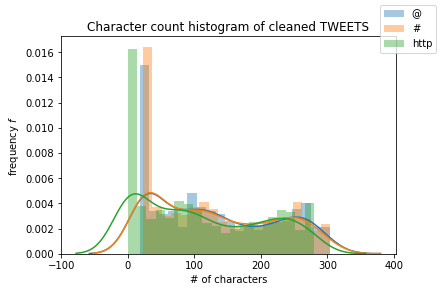


    Tabla de rangos de número de referencias
    (menciones-@, cadenas-#, links) vs
    frecuencia para los Tweets/Retweets



,max # chars,freq:@,freq:#,freq:http
0,50.0,214,214,276
1,100.0,132,133,142
2,150.0,135,132,92
3,200.0,81,88,86
4,250.0,98,104,120
5,300.0,113,101,68
6,350.0,11,12,0
7,400.0,0,0,0
8,450.0,0,0,0
9,500.0,0,0,0


In [18]:
fig = plt.figure()
rangos = (50,100,150,200,250,300,350,400,450,500,np.inf)
tmpdf = pd.DataFrame(rangos,columns=['max # chars'])
for rSeq in ('@','#','http'):
    print("Removiendo: %s..."%rSeq)
    tmparr = mined_tweets.loc[
        mined_tweets.retweet_text == 'none','text'
    ].apply(
        lambda x: len(filter_refs(
            x,
            {rSeq:True},
            invert=False
        )[1])
    )
    num_tweets = [ np.sum(tmparr <= it) for it in rangos ]
    num_tweets = [ nt - (
        num_tweets[it-1] if it > 0 else 0
    ) for it,nt in enumerate(num_tweets) ]
    tmpdf['freq:'+rSeq] = num_tweets
    sns.distplot(
        tmparr,bins=20
    )
fig.legend(labels=('@','#','http'))
ax = fig.get_axes()
ax[0].set_title('Character count histogram of cleaned TWEETS')
ax[0].set_xlabel('# of characters')
ax[0].set_ylabel('frequency $f$')
plt.show()
print("""
    Tabla de rangos de número de referencias
    (menciones-@, cadenas-#, links) vs
    frecuencia para los Tweets/Retweets
""")
tmpdf

#### Limpiar Retweets de referencias

Removiendo: @...
Removiendo: #...
Removiendo: http...


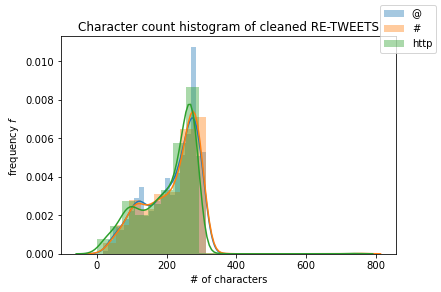


    Tabla de rangos de número de referencias
    (menciones-@, cadenas-#, links) vs
    frecuencia para los Tweets/Retweets



,max # chars,freq:@,freq:#,freq:http
0,50.0,28,23,51
1,100.0,91,89,134
2,150.0,165,159,130
3,200.0,175,178,182
4,250.0,243,228,249
5,300.0,430,461,462
6,350.0,79,71,2
7,400.0,0,1,0
8,450.0,0,0,0
9,500.0,0,0,0


In [19]:
fig = plt.figure()
rangos = (50,100,150,200,250,300,350,400,450,500,np.inf)
tmpdf = pd.DataFrame(rangos,columns=['max # chars'])
for rSeq in ('@','#','http'):
    print("Removiendo: %s..."%rSeq)
    tmparr = mined_tweets.loc[
        mined_tweets.retweet_text != 'none','retweet_text'
    ].apply(
        lambda x: len(filter_refs(
            x,
            {rSeq:True},
            invert=False
        )[1])
    )
    num_tweets = [ np.sum(tmparr <= it) for it in rangos ]
    num_tweets = [ nt - (
        num_tweets[it-1] if it > 0 else 0
    ) for it,nt in enumerate(num_tweets) ]
    tmpdf['freq:'+rSeq] = num_tweets
    sns.distplot(
        tmparr,bins=20
    )
fig.legend(labels=('@','#','http'))
ax = fig.get_axes()
ax[0].set_title('Character count histogram of cleaned RE-TWEETS')
ax[0].set_xlabel('# of characters')
ax[0].set_ylabel('frequency $f$')
plt.show()
print("""
    Tabla de rangos de número de referencias
    (menciones-@, cadenas-#, links) vs
    frecuencia para los Tweets/Retweets
""")
tmpdf

In [20]:
print("cleaning!")
del tmparr1, tmparr1a, tmparr2, tmparr2a

cleaning!


## Histograma de número de palabras usadas

Aquí debemos hacer distinción de $2^5=32$ posibles casos:
* Con y sin referencias: vínculos (http...), cadenas (#), y menciones (@)
> Para reducir el número de casos a los que yo considero conveniente, voy a filtrar en el primer numeral los vínculos a sitios web y voy a dejar las menciones y cadenas
* Con y sin Emojis
* Con y sin puntuación$+$"stopwords"

**Crear un vector de palabras únicas:**

Pueden usar ```set(['p1','p2','p3',...])```

<mark>Nota 1:</mark> pueden hacer un prefiltrado usando lo que se conoce como **stopwords** (más información acceda [aquí](https://www.ranks.nl/stopwords)) y la herramienta para hacerlo es [NLTK (Natural Language ToolKit)](https://github.com/nltk/nltk/tree/develop/nltk). Aquí les dejo el [link!](https://stackoverflow.com/questions/5541745/get-rid-of-stopwords-and-punctuation)

<mark>Nota 2:</mark> para los histogramas usen ```plt.hist``` o ```sns.distplot``` el que sea de su preferencia. Algo interesante es aprender a usar las nubes de palabras. Aquí les dejo un [ejemplo interesante de GOT](https://kaparker.com/posts/creating-word-clouds-with-python) ([otra opción más sofisticada](https://www.datacamp.com/community/tutorials/wordcloud-python)) y la [¡librería!](https://github.com/amueller/word_cloud)

### Sólo Tweets:
* Filtrar vinculos
* Filtrar si/no emojis
* Filtrar si/no "stop words"

Opción: +Emojis +SW
Opción: -Emojis +SW
Opción: +Emojis -SW
Opción: -Emojis -SW


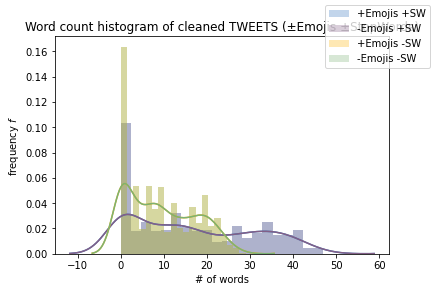

In [21]:
fig = plt.figure()
# las opciones se eligen por filtro de emoji,"stop words"
opciones = [(False,False),(True,False),(False,True),(True,True)]
legend = ['+Emojis +SW','-Emojis +SW','+Emojis -SW','-Emojis -SW']
colors = [
    sns.xkcd_rgb["windows blue"],
    sns.xkcd_rgb["dusty purple"],
    sns.xkcd_rgb["amber"],
    sns.xkcd_rgb["faded green"]
]
for it,(optEMOJI,optSW) in enumerate(opciones):
    print('Opción:',legend[it])
    sns.distplot(mined_tweets.loc[
        mined_tweets.retweet_text == 'none','text'
    ].apply(
        lambda x: len(
            filter_punc_n_stopwords(
                filter_emoji(
                    filter_refs(x,{'http':True},invert=False)[1],
                    remove=optEMOJI,
                    invert=False
                )[1],
                stops=optSW
            )
        )
    ),bins=20,color=colors[it],hist_kws=dict(alpha=0.3))
fig.legend(labels=legend)
ax = fig.get_axes()
ax[0].set_title('Word count histogram of cleaned TWEETS (\u00B1Emojis \u00B1StopWords)')
ax[0].set_xlabel('# of words')
ax[0].set_ylabel('frequency $f$')
plt.show()

Sería interesante mirar los histogramas de frecuencia de uso de emojis y también de uso de referencias.
1. \# emojis por Tweet
1. Los 10 emojis más frecuentes
1. \# de referencias por Tweet (discrimada por tipo)
1. Las 10 menciones más frecuentes
1. Las 10 cadenas más frecuentes

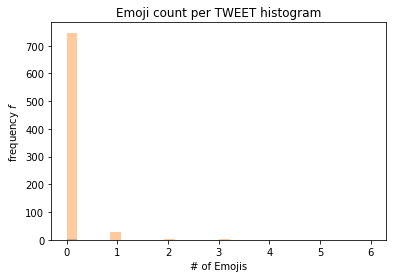

In [22]:
tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: sum(filter_emoji(x,remove=True,invert=False)[0].values())
)
try:
    sns.distplot(tmpdata)
except RuntimeError:
    sns.distplot(tmpdata,kde=False)
del tmpdata
ax = plt.gca()
ax.set_title('Emoji count per TWEET histogram')
ax.set_xlabel('# of Emojis')
ax.set_ylabel('frequency $f$')
plt.show()

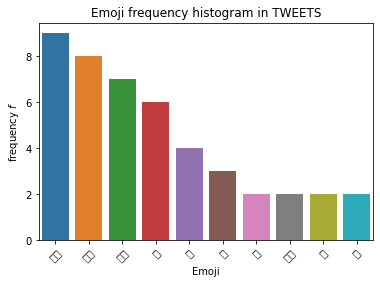

Most common emojis:
	 ['🇨🇴' '👇🏻' '👏🏼' '👏' '💝' '📻' '🙏' '👇🏼' '🏆' '👹']


In [24]:
count = Counter({});tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: filter_emoji(x,remove=True,invert=False,translate=False)[0]
)
for c in tmpdata:
    count+=c
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
h.set_title('Emoji frequency histogram in TWEETS')
h.set_xlabel('Emoji')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common emojis:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

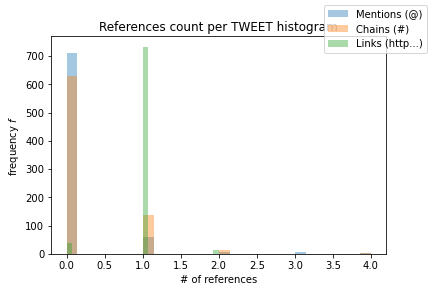

In [25]:
fig = plt.figure()
tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: filter_refs(x,invert=False)[0]
)
sns.distplot(tmpdata.apply(lambda x: x['@']),kde=False)
sns.distplot(tmpdata.apply(lambda x: x['#']),kde=False)
sns.distplot(tmpdata.apply(lambda x: x['http']),kde=False)
fig.legend(labels=['Mentions (@)','Chains (#)','Links (http...)'])
ax = fig.get_axes()
ax[0].set_title('References count per TWEET histogram')
ax[0].set_xlabel('# of references')
ax[0].set_ylabel('frequency $f$')
plt.show()

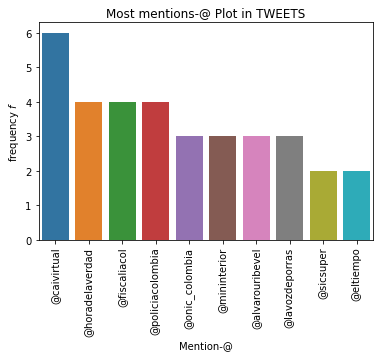

Most common Mentions:
	 ['@caivirtual' '@horadelaverdad' '@fiscaliacol' '@policiacolombia'
 '@onic_colombia' '@mininterior' '@alvarouribevel' '@lavozdeporras'
 '@sicsuper' '@eltiempo']


In [26]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: filter_punc_n_stopwords(
       filter_refs(
        x,
        {'@':True,'#':False,'http':False},
        invert=True
    )[1],stops=False
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most mentions-@ Plot in TWEETS')
h.set_xlabel('Mention-@')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common Mentions:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

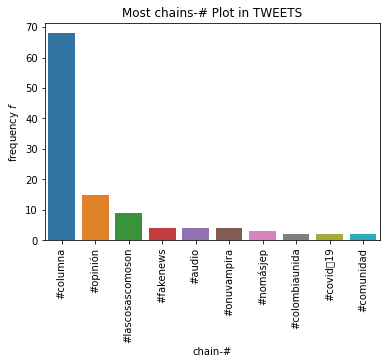

Most common emojis:
	 ['#columna' '#opinión' '#lascosascomoson' '#fakenews' '#audio'
 '#onuvampira' '#nomásjep' '#colombiaunida' '#covidー19' '#comunidad']


In [28]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: filter_punc_n_stopwords(
       filter_refs(
        x,
        {'@':False,'#':True,'http':False},
        invert=True
    )[1],stops=False
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most chains-# Plot in TWEETS')
h.set_xlabel('chain-#')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common emojis:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

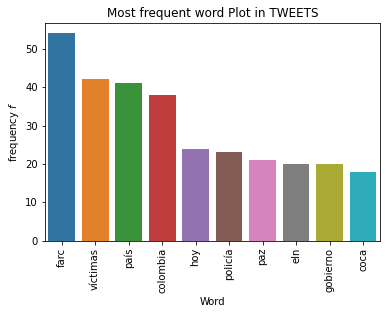

Most common Words:
	 ['farc' 'víctimas' 'país' 'colombia' 'hoy' 'policía' 'paz' 'eln'
 'gobierno' 'coca']


In [29]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text == 'none','text'
].apply(
    lambda x: filter_punc_n_stopwords(
        filter_refs(
            filter_emoji(x,remove=True,invert=False,translate=False)[1],
            {'@':True,'#':True,'http':True},
            invert=False
        )[1],stops=True
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most frequent word Plot in TWEETS')
h.set_xlabel('Word')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common Words:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

### Sólo Retweets:
* Filtrar vinculos
* Filtrar si/no emojis
* Filtrar si/no "stop words"

Opción: +Emojis +SW
Opción: -Emojis +SW
Opción: +Emojis -SW
Opción: -Emojis -SW


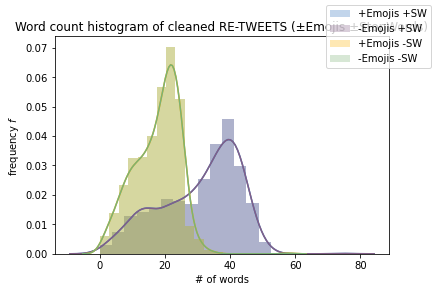

In [30]:
fig = plt.figure()
# las opciones se eligen por filtro de emoji,"stop words"
opciones = [(False,False),(True,False),(False,True),(True,True)]
legend = ['+Emojis +SW','-Emojis +SW','+Emojis -SW','-Emojis -SW']
colors = [
    sns.xkcd_rgb["windows blue"],
    sns.xkcd_rgb["dusty purple"],
    sns.xkcd_rgb["amber"],
    sns.xkcd_rgb["faded green"]
]
for it,(optEMOJI,optSW) in enumerate(opciones):
    print('Opción:',legend[it])
    sns.distplot(mined_tweets.loc[
        mined_tweets.retweet_text != 'none','retweet_text'
    ].apply(
        lambda x: len(
            filter_punc_n_stopwords(
                filter_emoji(
                    filter_refs(x,{'http':True},invert=False)[1],
                    remove=optEMOJI,
                    invert=False
                )[1],
                stops=optSW
            )
        )
    ),bins=20,color=colors[it],hist_kws=dict(alpha=0.3))
fig.legend(labels=legend)
ax = fig.get_axes()
ax[0].set_title('Word count histogram of cleaned RE-TWEETS (\u00B1Emojis \u00B1StopWords)')
ax[0].set_xlabel('# of words')
ax[0].set_ylabel('frequency $f$')
plt.show()

Sería interesante mirar los histogramas de frecuencia de uso de emojis y también de uso de referencias.
1. \# emojis por Tweet
1. Los 10 emojis más frecuentes
1. \# de referencias por Tweet (discrimada por tipo)
1. Las 10 menciones más frecuentes
1. Las 10 cadenas más frecuentes

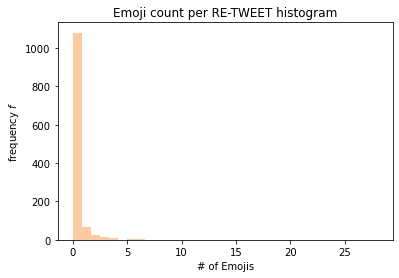

In [31]:
tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: sum(filter_emoji(x,remove=True,invert=False)[0].values())
)
try:
    sns.distplot(tmpdata)
except RuntimeError:
    sns.distplot(tmpdata,kde=False)
del tmpdata
ax = plt.gca()
ax.set_title('Emoji count per RE-TWEET histogram')
ax.set_xlabel('# of Emojis')
ax.set_ylabel('frequency $f$')
plt.show()

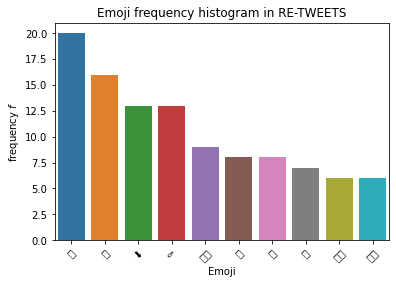

Most common emojis:
	 ['👏' '🤔' '⬇' '⚰' '🇨🇴' '👇' '🥚' '🚨' '🇧🇷' '🇨🇱']


In [33]:
count = Counter({});tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: filter_emoji(x,remove=True,invert=False,translate=False)[0]
)
for c in tmpdata:
    count+=c
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
h.set_title('Emoji frequency histogram in RE-TWEETS')
h.set_xlabel('Emoji')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common emojis:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

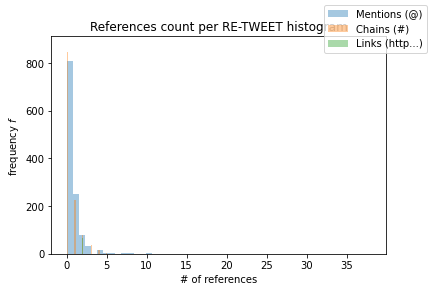

In [34]:
fig = plt.figure()
tmpdata = mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: filter_refs(x,invert=False)[0]
)
sns.distplot(tmpdata.apply(lambda x: x['@']),kde=False)
sns.distplot(tmpdata.apply(lambda x: x['#']),kde=False)
sns.distplot(tmpdata.apply(lambda x: x['http']),kde=False)
fig.legend(labels=['Mentions (@)','Chains (#)','Links (http...)'])
ax = fig.get_axes()
ax[0].set_title('References count per RE-TWEET histogram')
ax[0].set_xlabel('# of references')
ax[0].set_ylabel('frequency $f$')
plt.show()

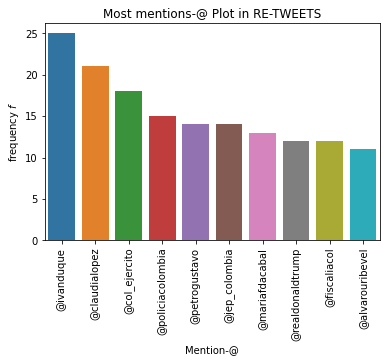

Most common @ mentions:
	 ['@ivanduque' '@claudialopez' '@col_ejercito' '@policiacolombia'
 '@petrogustavo' '@jep_colombia' '@mariafdacabal' '@realdonaldtrump'
 '@fiscaliacol' '@alvarouribevel']


In [35]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: filter_punc_n_stopwords(
       filter_refs(
        x,
        {'@':True,'#':False,'http':False},
        invert=True
    )[1],stops=False
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most mentions-@ Plot in RE-TWEETS')
h.set_xlabel('Mention-@')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common @ mentions:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

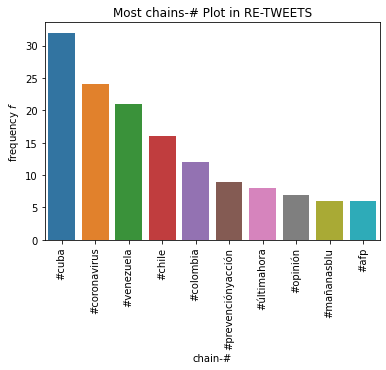

Most common # chains:
	 ['#cuba' '#coronavirus' '#venezuela' '#chile' '#colombia'
 '#prevenciónyacción' '#últimahora' '#opinión' '#mañanasblu' '#afp']


In [36]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: filter_punc_n_stopwords(
       filter_refs(
        x,
        {'@':False,'#':True,'http':False},
        invert=True
    )[1],stops=False
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most chains-# Plot in RE-TWEETS')
h.set_xlabel('chain-#')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common # chains:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

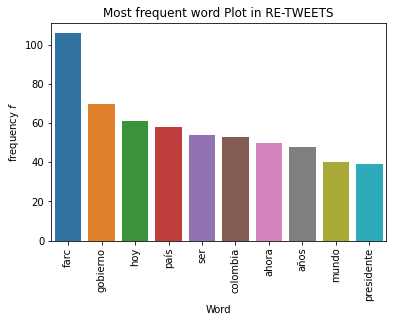

Most common Words:
	 ['farc' 'gobierno' 'hoy' 'país' 'ser' 'colombia' 'ahora' 'años' 'mundo'
 'presidente']


In [37]:
count = Counter({})
tmpdata = flatten(list(mined_tweets.loc[
    mined_tweets.retweet_text != 'none','retweet_text'
].apply(
    lambda x: filter_punc_n_stopwords(
        filter_refs(
            filter_emoji(x,remove=True,invert=False,translate=False)[1],
            {'@':True,'#':True,'http':True},
            invert=False
        )[1],stops=True
    )
)))
for td in tmpdata:
    if td in count.keys():
        count[td] += 1
    else:
        count[td] = 1
mostcommon=np.array(count.most_common(10))
h = sns.barplot(mostcommon[:,0],mostcommon[:,1])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
h.set_title('Most frequent word Plot in RE-TWEETS')
h.set_xlabel('Word')
h.set_ylabel('frequency $f$')
plt.show()
print("Most common Words:\n\t",mostcommon[:,0])
del h,tmpdata,count,mostcommon

# Ejemplo de FIFA

Se descarga un archivo comprimizo y se puede descomprimir como `unzip fifa-20-complete-player-dataset.zip` que tiene los siguientes contenidos
```bash
players_15.csv
players_16.csv
players_17.csv
players_18.csv
players_19.csv
players_20.csv
```
Cada archivo de texto tiene el mismo número de columnas y contiene información interesante. Los invito a que lo abran (Microsoft Excel, LibreOffice, o el de su preferencia) Si no quieren hacerlo, pueden mirar las columnas con el siguiente comando: e.g. `head -n1 players15.csv | sed 's/,/\n/g'` con el siguiente output:
```bash
sofifa_id
player_url
short_name
long_name
age
dob
height_cm
weight_kg
nationality
club
overall
potential
value_eur
wage_eur
player_positions
preferred_foot
international_reputation
weak_foot
skill_moves
work_rate
body_type
real_face
release_clause_eur
player_tags
team_position
team_jersey_number
loaned_from
joined
contract_valid_until
nation_position
nation_jersey_number
pace
shooting
passing
dribbling
defending
physic
gk_diving
gk_handling
gk_kicking
gk_reflexes
gk_speed
gk_positioning
player_traits
attacking_crossing
attacking_finishing
attacking_heading_accuracy
attacking_short_passing
attacking_volleys
skill_dribbling
skill_curve
skill_fk_accuracy
skill_long_passing
skill_ball_control
movement_acceleration
movement_sprint_speed
movement_agility
movement_reactions
movement_balance
power_shot_power
power_jumping
power_stamina
power_strength
power_long_shots
mentality_aggression
mentality_interceptions
mentality_positioning
mentality_vision
mentality_penalties
mentality_composure
defending_marking
defending_standing_tackle
defending_sliding_tackle
goalkeeping_diving
goalkeeping_handling
goalkeeping_kicking
goalkeeping_positioning
goalkeeping_reflexes
ls
st
rs
lw
lf
cf
rf
rw
lam
cam
ram
lm
lcm
cm
rcm
rm
lwb
ldm
cdm
rdm
rwb
lb
lcb
cb
rcb
rb
```

Para el ejercicio nos interesan: <u>nationality</u> y <u>overall</u> (¿quizás <u>potential</u>?)
Para cargar el archivo, por ejemplo `players_15.csv` y sólo esas columnas podemos usar el comando de Numpy [loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) o [genfromtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html). Aquí les dejo el dos scripts de ejemplo para cada comando:
```python
test1 = np.array(
    np.loadtxt(
        'players_15.csv', skiprows=1, usecols=(0,4,8,10,11), delimiter=',',
        dtype={
            'names': ('sofifa_id','age','nationality', 'overall', 'potential'),
            'formats': (np.int,np.int8,'S20', np.int8, np.int8)
        },
        unpack=True
    )
).T
print(test1)

test2 = np.array(
    np.genfromtxt(
        'players_15.csv', skip_header=True, usecols=(0,4,8,10,11), delimiter=',',
        dtype=None, names=('sofifa_id','age','nationality', 'overall', 'potential'),
        encoding=None, unpack=True
    )
).T
print(test2)

test3 = pd.read_csv(
    filepath_or_buffer='players_15.csv',
    sep=',',header=0,
    usecols=[0,4,8,10,11],
    dtype={
        'sofifa_id' : np.int,
        'age' : np.int8,
        'nationality' : str,
        'overall' : np.int8,
        'potential' : np.int8,
    }
)
test3
```

In [38]:
# Define certain functions:
def getContinent(s):
    import pycountry as pc
    import pycountry_convert as pcc
    lookuperrors = {
        'ivory coast':'AF',
        'republic of ireland': 'EU',
        'dr congo': 'AF',
        'trinidad & tobago': 'NA',
        'korea republic': 'AS',
        'fyr macedonia': 'EU',
        'bosnia herzegovina': 'EU',
        'st kitts nevis': 'NA',
        'antigua & barbuda': 'NA',
        'cape verde': 'AF',
        'guinea bissau': 'AF',
        'central african rep.': 'AF',
        'korea dpr': 'AS',
        'st lucia': 'NA',
        'china pr': 'AS',
        'chinese taipei': 'AS',
        'são tomé & príncipe': 'AF',
        'st vincent grenadine': 'NA',
        'swaziland': 'AF',
        'macau': 'AS'
    }
    try:
        country = pc.countries.search_fuzzy(pc.remove_accents(s))
    except LookupError as err:
        try:
            return lookuperrors[s]
        except:
            return '__'
    return pcc.country_alpha2_to_continent_code(country[0].alpha_2)
def createContinent(data=[]):
    # 1. Get the set of all possible countries
    countries = {}
    for datx in data:
        for ct in datx:
            countries[ct] = None
    # 2. Get continent
    for ct in countries.keys():
        countries[ct] = getContinent(ct)
    # 3. Print mismatches to improve function
    for key,value in countries.items():
        if value == '__':
            print('NEW Mismatch:',key)
    return countries.copy()

In [39]:
directory = 'tmpdata/'
years = (15,16,17,18,19,20)
# Load data
print("Loading Data")
fifa_data = {
    y:np.array(
        np.loadtxt(
            directory+'players_'+str(y)+'.csv', skiprows=1, usecols=(0,4,8,10,11), delimiter=',',
            dtype={
                'names': ('sofifa_id','age','nationality', 'overall', 'potential'),
                'formats': (np.int,np.int8,'U20', np.int8, np.int8)
            }
        )
    ) for y in years
}
# Sort rows by sofifa_id
print("Sorting Data")
fifa_data = { y:datx[np.argsort(np.array([el[0] for el in datx]))] for y,datx in fifa_data.items() }
# Convert each data into a dictionary
print("Converting Data")
fifa_data = {
    y:{
        'id':np.array([el[0] for el in datx]),
        'age':np.array([el[1] for el in datx]),
        'nat':np.array([el[2].lower() for el in datx]),
        'ove':np.array([el[3] for el in datx]),
        # 'cont':np.array([getContinent(el[2].lower()) for index,el in tqdm(np.ndenumerate(datx))])

    }
    for y,datx in fifa_data.items()
}
del directory

Loading Data
Sorting Data
Converting Data


In [40]:
# Create continent dictionary
print("Creating continent dictionary")
dict_of_countries = createContinent([
    datx['nat'] for y,datx in fifa_data.items()
])
# Create continent "key" or column
print("Creating continent 'key'")
for y in years:
    fifa_data[y]['cont'] = np.array([dict_of_countries[ct] for ct in fifa_data[y]['nat']])

Creating continent dictionary
Creating continent 'key'


In [41]:
# Create the improve dictionary (remove id's and overall)
improvement = {
    'age' : np.array([],dtype=np.int8),
    'delta' : np.array([],dtype=np.int8),
    'cont' : np.array([])
}
# Find intersects to update the im
for it in range(len(years)-1):
    ys = years[it:it+2]
    common_ids = np.intersect1d(fifa_data[ys[0]]['id'],fifa_data[ys[1]]['id'])
    id1 = np.isin(fifa_data[ys[0]]['id'],common_ids)
    id2 = np.isin(fifa_data[ys[1]]['id'],common_ids)
    improvement['age'] = np.concatenate((improvement['age'],fifa_data[ys[0]]['age'][id1]))
    improvement['cont'] = np.concatenate((improvement['cont'],fifa_data[ys[0]]['cont'][id1]))
    improvement['delta'] = np.concatenate((improvement['delta'],fifa_data[ys[1]]['ove'][id2]-fifa_data[ys[0]]['ove'][id1]))

In [42]:
# this function returns the counts for improvements
def getN(v):
    N = {
        'mejora':0,
        'desmejora':0,
        'igual':0
    }
    def updateN(v):
        if v == 0:
            N['igual'] += 1
        elif v > 0:
            N['mejora'] += 1
        else:
            N['desmejora'] += 1
    V_updateN = np.vectorize(updateN)
    if len(v) > 0:
        V_updateN(v)
    # updates proportions
    Ntot = max(1,np.sum(list(N.values())))
    for key in N.keys():
        N[key] = [N[key]/Ntot]
    N['#'] = [Ntot]
    return N.copy()

## Tablas: totales, dependiendo de la edad, dependiendo del continente, y dependiendo de la edad/continente
> Vamos a filtrar datos con más de 100 puntos

In [43]:
print("Probabilidad total -frecuentista- de mejorar, desmejorar o mantenerse igual:")
df_totals = pd.DataFrame.from_dict(getN(improvement['delta']))
df_totals = df_totals[df_totals['#'] > 100]
df_totals

Probabilidad total -frecuentista- de mejorar, desmejorar o mantenerse igual:


,mejora,desmejora,igual,#
0,0.545084,0.221886,0.23303,59400


In [44]:
print("Probabilidad por edades -frecuentista- de mejorar, desmejorar o mantenerse igual:")
ages = np.unique(improvement['age'])
df_age = pd.DataFrame(columns=['edad','#','mejora','desmejora','igual'])
for age in ages:
    tmpdf = pd.DataFrame.from_dict(getN(improvement['delta'][improvement['age'] == age]))
    tmpdf['edad'] = age
    df_age = pd.concat((df_age,tmpdf),ignore_index=True)
    del tmpdf
df_age = df_age[df_age['#'] > 100]
df_age

Probabilidad por edades -frecuentista- de mejorar, desmejorar o mantenerse igual:


,edad,#,mejora,desmejora,igual
1,17,845,0.769231,0.054438,0.176331
2,18,2130,0.772770,0.044131,0.183099
3,19,3223,0.745579,0.071983,0.182439
4,20,4011,0.720519,0.084019,0.195462
5,21,4465,0.688018,0.129003,0.182979
6,22,4725,0.655238,0.145185,0.199577
7,23,4833,0.609559,0.187461,0.202980
8,24,4849,0.563209,0.205197,0.231594
9,25,4697,0.530977,0.224186,0.244837
10,26,4565,0.495728,0.253012,0.251260


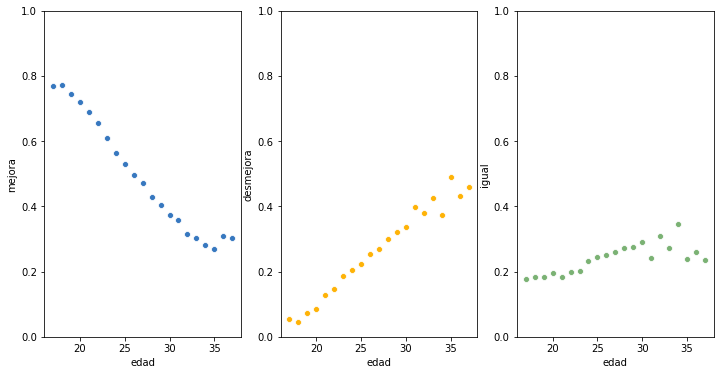

In [45]:
fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
sns.scatterplot(x="edad", y="mejora", data=df_age, ax=ax_l, color=sns.xkcd_rgb["windows blue"])
sns.scatterplot(x="edad", y="desmejora", data=df_age, ax = ax_c, color=sns.xkcd_rgb["amber"])
sns.scatterplot(x="edad", y="igual", data=df_age, ax = ax_r, color=sns.xkcd_rgb["faded green"])
ax_l.set_ylim(0,1); ax_c.set_ylim(0,1); ax_r.set_ylim(0,1);
del fig, ax_l, ax_c, ax_r

In [46]:
print("Probabilidad por continentes -frecuentista- de mejorar, desmejorar o mantenerse igual:")
conts = np.unique(improvement['cont'])
df_cont = pd.DataFrame(columns=['continente','#','mejora','desmejora','igual'])
for cont in conts:
    tmpdf = pd.DataFrame.from_dict(getN(improvement['delta'][improvement['cont'] == cont]))
    tmpdf['continente'] = cont
    df_cont = pd.concat((df_cont,tmpdf),ignore_index=True)
    del tmpdf
df_cont = df_cont[df_cont['#'] > 100]
df_cont

Probabilidad por continentes -frecuentista- de mejorar, desmejorar o mantenerse igual:


,continente,#,mejora,desmejora,igual
0,AF,3847,0.549259,0.236808,0.213933
1,AS,4780,0.486402,0.258787,0.254812
2,EU,36881,0.562132,0.219300,0.218568
3,NA,3274,0.518326,0.230910,0.250764
4,OC,838,0.564439,0.207637,0.227924
5,SA,9785,0.515074,0.206132,0.278794


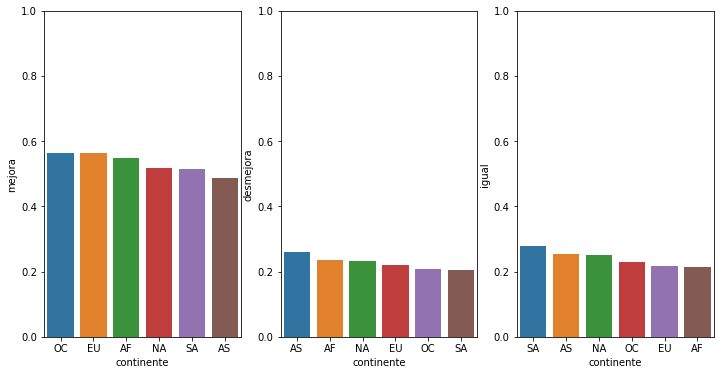

In [47]:
fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
sns.barplot(x="continente", y="mejora", data=df_cont, ax=ax_l, order=df_cont.sort_values('mejora',ascending=False)['continente'])
sns.barplot(x="continente", y="desmejora", data=df_cont, ax = ax_c, order=df_cont.sort_values('desmejora',ascending=False)['continente'])
sns.barplot(x="continente", y="igual", data=df_cont, ax = ax_r, order=df_cont.sort_values('igual',ascending=False)['continente'])
ax_l.set_ylim(0,1); ax_c.set_ylim(0,1); ax_r.set_ylim(0,1);
del fig, ax_l, ax_c, ax_r

In [48]:
print("Probabilidad por edades y continentes -frecuentista- de mejorar, desmejorar o mantenerse igual:")
ages = np.unique(improvement['age'])
conts = np.unique(improvement['cont'])
df_age_cont = pd.DataFrame(columns=['continente','edad','#','mejora','desmejora','igual'])
for cont in conts:
    for age in ages:
        tmpdf = pd.DataFrame.from_dict(
            getN(improvement['delta'][
                np.logical_and(
                    improvement['cont'] == cont,
                    improvement['age'] == age
                )
            ])
        )
        tmpdf['edad'] = age
        tmpdf['continente'] = cont
        df_age_cont = pd.concat((df_age_cont,tmpdf),ignore_index=True)
        del tmpdf
df_age_cont = df_age_cont[df_age_cont['#'] > 100]
df_age_cont

Probabilidad por edades y continentes -frecuentista- de mejorar, desmejorar o mantenerse igual:


,continente,edad,#,mejora,desmejora,igual
2,AF,18,116,0.810345,0.060345,0.129310
3,AF,19,201,0.756219,0.084577,0.159204
4,AF,20,287,0.707317,0.083624,0.209059
5,AF,21,306,0.722222,0.124183,0.153595
6,AF,22,344,0.651163,0.177326,0.171512
...,...,...,...,...,...,...
170,SA,31,380,0.407895,0.331579,0.260526
171,SA,32,406,0.298030,0.285714,0.416256
172,SA,33,334,0.299401,0.335329,0.365269
173,SA,34,295,0.216949,0.240678,0.542373


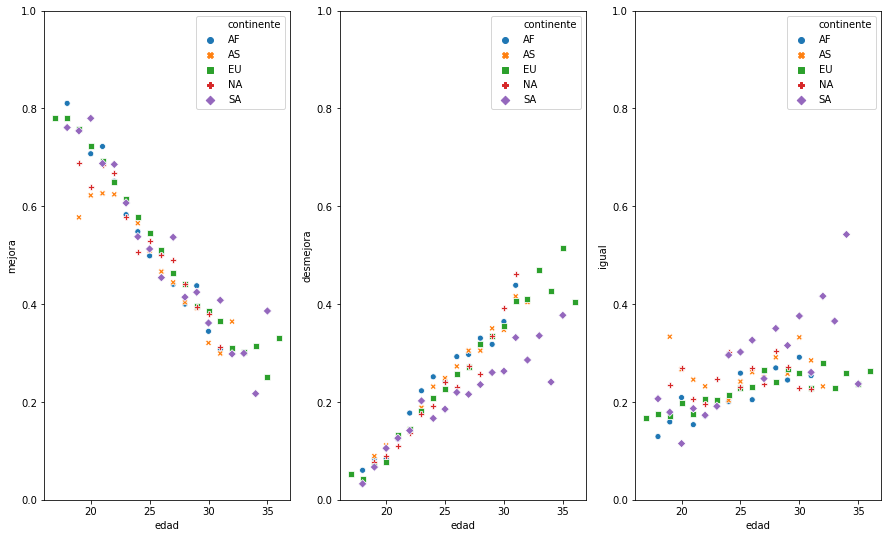

In [49]:
fig, (ax_l, ax_c, ax_r) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 9))
sns.scatterplot(x="edad", y="mejora", data=df_age_cont, hue='continente', style='continente', ax=ax_l)
sns.scatterplot(x="edad", y="desmejora", data=df_age_cont, hue='continente', style='continente', ax = ax_c)
sns.scatterplot(x="edad", y="igual", data=df_age_cont, hue='continente', style='continente', ax = ax_r)
ax_l.set_ylim(0,1); ax_c.set_ylim(0,1); ax_r.set_ylim(0,1);
del fig, ax_l, ax_c, ax_r